In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import collections

In [5]:
class GridWorld:
    
    """Gridworld as MDP"""
    def __init__(self, m, n):
        """ initializes the gridworld
        """
        self.m = m
        self.n = n
        self.grid = np.zeros(shape = (m,n))
        self.end = False
        self.goal_tile = 60
        self.wall_tile = 100
        self.ice_tile = 30
        self.figure = 0
        self.free_tile = 230
        # fill the grid with free tiles
        for i in range(self.m):
            for j in range(self.n):
                self.grid[i,j] = self.free_tile
        # possible actions
        self.actions = ["up", "down", "right", "left"]

        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
    
        self.grid[1][1] = self.ice_tile
        self.grid[1][4]= self.ice_tile
        self.grid[1][3] = self.wall_tile
        
    def reset(self):
        """ resets the gridworld
        """
        self.end = False
        #startpoint of the agent
        self.grid[0][0] = self.figure
        
        #goal position
        self.grid[self.m-1][self.n-1] = self.goal_tile
        
        self.grid[1][1] = self.ice_tile
        self.grid[1][4] = self.ice_tile

    def __getitem__(self, grid):
        """ returns the grid

        Args:
            grid (np_array): gridworld
        """
        print(self.grid)
        return self.grid

    # a function that returns the four tiles that are visible to the agent
    def visible_tiles(self):
        """ returns the four tiles that are visible to the agent
        """
        x,y = self.current_pos()
        visible_tiles = []
        for i in self.actions:
            next, next_two, con, con2 = self.action_parameter(i)
            if con == True:
                visible_tiles.append(self.grid[next])
        return visible_tiles
        
    def visualize_grid(self):
        """ visualizes the gridworld
        """
        fig, ax = plt.subplots()
        ax.matshow(self.grid, cmap = 'Pastel1')
        for i in range(self.grid.shape[1]):
            for j in range(self.grid.shape[0]):
                # create a string for the label of each tile in the right format
                if str(self.grid[j,i]) == str(float(self.free_tile)):
                    label = " "
                elif str(self.grid[j,i]) == str(float(self.wall_tile)):
                    label = "wall"
                elif str(self.grid[j,i]) == str(float(self.ice_tile)):
                    label = "ice"
                elif str(self.grid[j,i]) == str(float(self.goal_tile)):
                    label = "goal"
                elif str(self.grid[j,i]) == str(float(self.figure)):
                    label = "agent"
                else:
                    label = str(self.grid[j,i])
                ax.text(i, j, label, va = 'center', ha = 'center')
        plt.show()

    def current_pos(self):
        """ returns the current position of the agent
        """
        found = False
        for x in range(self.m):
            for y in range(self.n):
                if self.grid[x,y] == self.figure:
                    found = True
                    break
            if found == True:
                break
        return x,y
    
    def action_parameter(self, action):
        """ returns the next tile and the tile after the next tile and if the next tile is in the grid

        Args:
            action (str): action that the agent should take
        """
        x, y = self.current_pos()
        con = False
        con2 = False
        if action == "up":
            next = x-1,y
            next_two = x-2,y
            if x-1 >= 0:
                con = True
            if x-2 >= 0:
                con2 = True

        elif action == "down":
            next = x+1,y
            next_two = x+2,y
            if x+1 <= self.m-1:
                con = True
            if x+2 <= self.m-1:
                con2 = True

        elif action == "right":
            next = x,y+1
            next_two = x,y+2
            if y+1 <= self.n-1:
                con = True
            if y+2 <= self.n-1:
                con2 = True
        elif action == "left":
            next = x,y-1
            next_two = x,y-2
            if y-1 >= 0:
                con = True
            if y-2 >= 0:
                con2 = True
        return next, next_two, con, con2
            
    def move(self, action):
        """ move the agent according to the action

        Args:
            action (str):  action that the agent should take
        """
        if action != None:
            next, next_two, con, con2 = self.action_parameter(action)
            x, y = self.current_pos()
            if con == True:
                self.grid[x,y] = self.free_tile
                # if the agent reaches the goal, the game ends
                if self.grid[next] == self.goal_tile:
                    # self.grid[next] = self.figure
                    self.end = True
                # if the agent reaches an icy tile, it moves two steps left
                elif self.grid[next] == self.ice_tile and con2 == True:
                    if self.grid[next_two] == self.goal_tile:
                        # self.grid[next_two] == self.figure
                        self.end = True
                    elif self.grid[next_two] == self.wall_tile:
                        self.grid[next] = self.figure
                    else:
                        self.grid[next_two] = self.figure          
                # if the agent reaches a wall, it cannot move
                elif self.grid[next] == self.wall_tile:
                    self.grid[x,y] = self.figure
                elif self.grid[next] == self.free_tile:
                    self.grid[next] = self.figure

    def get_reward(self, next):
        """ Returns the reward of the agent

        Args:
            next (tuple): next position of the agent
        """
        if next == self.goal_tile:
            return 100
        else:
            return -1

    def initialize_policy(self):
        """ Initializes the policy of the agent
        """
        policy = np.zeros(shape = (self.m, self.n, len(self.actions)))
        for i in range(self.m):
            for j in range(self.n):
                for k in range(len(self.actions)):
                    policy[i,j,k] = 1/len(self.actions)
        return policy


    def mc_estimation(self, num_episodes, gamma, epsilon):
        """Monte Carlo estimation

        Args:
            num_episodes (int): number of episodes
            gamma (int): discount factor
            epsilon (int): epsilon
        """
        # initialize the value function
        value = np.zeros(shape = (self.m, self.n))
        # initialize the policy
        policy = self.initialize_policy()
        #Q = np.zeros(shape = (self.m, self.n, len(self.actions)))
        average_returns = []
        # time
        time_per_episode = []
        returns = {}
        list = []
        # initialize seen states
        seen_states = []
        # define q function
        Q = {}
        
        for i in tqdm(range(num_episodes)):
            # initialize the episode
            G = 0
            episode = []
            seen_states = []
            #self.end = False
            rewards = []
            # reset the grid
            self.reset()
            # time each episode
            time_start = time.time()
            # loop over the episode
            while self.end == False:
                # choose an action
                old_position = self.current_pos()
                # choose an action with the highest policy
                action_list = []
                x, y = self.current_pos()
                for k in range(len(self.actions)):
                    if policy[x,y,k] == np.max(policy[x,y]):
                        action_list.append(self.actions[k])
                
                    
                action = np.random.choice(action_list)
                #print(action_list)
                action_list.clear()
                # take the action and observe the next state and reward
                self.move(action)
                # add the state to the episode
                episode.append((old_position, action, self.get_reward(self.grid[self.current_pos()])))
                # check if the episode is done
                if self.current_pos() == self.goal_tile:
                    self.end = True
                # add the reward to the rewards list
                rewards.append(self.get_reward(self.grid[self.current_pos()]))

            # end time
            time_end = time.time()
            # calculate the time
            time_episode = time_end - time_start
            # add the time to the time list
            time_per_episode.append(time_episode)
            
            # loop over the episode
            for j in range(len(episode)):
                # get the state, action and reward
                state = episode[j][0]
                action = episode[j][1]
                reward = episode[j][2]
                # calculate the return
                G = gamma * G + reward
                # add the return to the returns list
                list.append(G)
                # if the state is not in the seen states
                if state not in seen_states:
                    # add the state to the seen states
                    seen_states.append(state)
                    # add the return to the returns dictionary
                    returns[state] = [G]
                else:
                    # append the return to the returns dictionary
                    returns[state].append(G)

                # calculate the average return
                average_return = np.mean(returns[state])
                # update the value function
                value[state] = average_return
                # update the q function
                if state not in Q.keys():
                    Q[state] = np.zeros(len(self.actions))

                # update the q function
                # transform the action to an integer
                Q[state][self.actions.index(action)] = average_return
            
                # # update the policy
                for k in range(len(self.actions)):
                    if k == action:
                        policy[state[0], state[1], k] = 1 - epsilon + epsilon/len(self.actions)
                    else:
                        policy[state[0], state[1], k] = epsilon/len(self.actions)
                            
            # add the average return to the list
            average_returns.append(np.mean(list))
            # clear the list
            list.clear()
            # epsilon annealing
            epsilon = epsilon * 0.99
                          
        return policy, returns, value, average_returns, time_per_episode

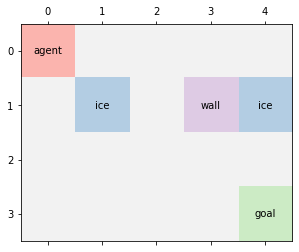

  0%|          | 0/1000 [00:00<?, ?it/s]

[[-10.62345966 -12.84262742 -12.45292795  -9.19279825 -17.64311095]
 [ -8.33979906   0.          -4.44287704   0.           0.        ]
 [-14.99311821 -10.72198352  -7.24139246 -11.8572468   81.92139598]
 [-15.24346229 -15.48128918  -9.51210059  11.10589932   0.        ]]


In [6]:
env = GridWorld(4,5)
from sklearn.preprocessing import normalize

env.visualize_grid()
policy = env.initialize_policy()
policy, returns, value, average_returns, time_episode = env.mc_estimation(1000, 0.95, 0.1)
print(value)
# self.actions = ["up", "down", "right", "left"]

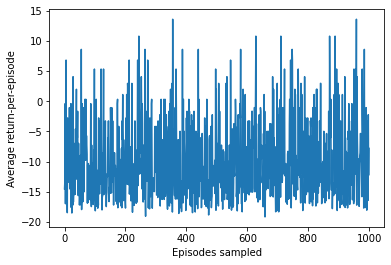

In [7]:
#visualize average return-per-episode in episodes-sampled
x = list(range(1000))
# print(average_returns)
y = average_returns
# print(average_returns)
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Average return-per-episode')
plt.show()

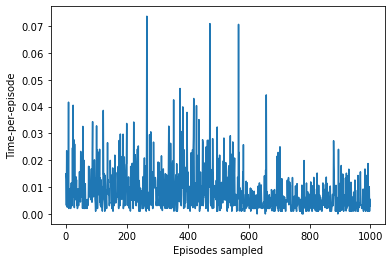

In [8]:
# visualize the time-per-episode in episodes-sampled
x = list(range(1000))
y = time_episode
plt.plot(x,y)
plt.xlabel('Episodes sampled')
plt.ylabel('Time-per-episode')
plt.show()
